In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from statsmodels.regression.linear_model import WLS
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import reset_ramsey
import statsmodels.stats.diagnostic as smsdia
from sklearn.metrics import mean_squared_error
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.graphics.regressionplots import plot_leverage_resid2
%matplotlib inline

## 1. Загрузка данных

In [2]:
data = pd.read_csv('data/hotel_data.csv', sep=';')

In [3]:
data.head()

,Hotel name,Rating,Stars,Distance to the sea,Distance to the downtown,Room area,Swimming pool,Price
0,Bonanova Park,7.7,2.0,7.0,5.0,16.0,0,63
1,Travelodge Barcelona Poblenou,7.9,1.0,0.5,2.0,15.0,0,83
2,Senator Barcelona Spa Hotel,7.8,4.0,5.0,3.0,21.0,1,91
3,Hotel Medicis,7.9,2.0,2.0,1.0,10.0,0,87
4,Paral-lel,8.4,2.0,0.5,1.0,19.0,0,102


### 1.1 Описание данных

In [4]:
data.describe()

,Rating,Stars,Distance to the sea,Distance to the downtown,Room area,Swimming pool,Price
count,208.000000,207.000000,208.000000,208.000000,207.000000,208.000000,208.000000
mean,7.980288,3.260870,2.585096,1.258173,18.483092,0.250000,129.754808
std,0.491125,0.841615,1.656875,1.168520,5.172599,0.434057,29.895025
min,6.400000,1.000000,0.000000,0.000000,8.000000,0.000000,63.000000
25%,7.700000,3.000000,1.500000,0.500000,15.000000,0.000000,107.000000
50%,8.000000,3.000000,2.500000,1.000000,18.000000,0.000000,126.000000
75%,8.300000,4.000000,3.000000,2.000000,21.000000,0.250000,151.250000
max,9.000000,4.000000,9.000000,5.000000,44.000000,1.000000,210.000000


Также посмотрим на медианы

In [5]:
data.median()

Rating                        8.0
Stars                         3.0
Distance to the sea           2.5
Distance to the downtown      1.0
Room area                    18.0
Swimming pool                 0.0
Price                       126.0
dtype: float64

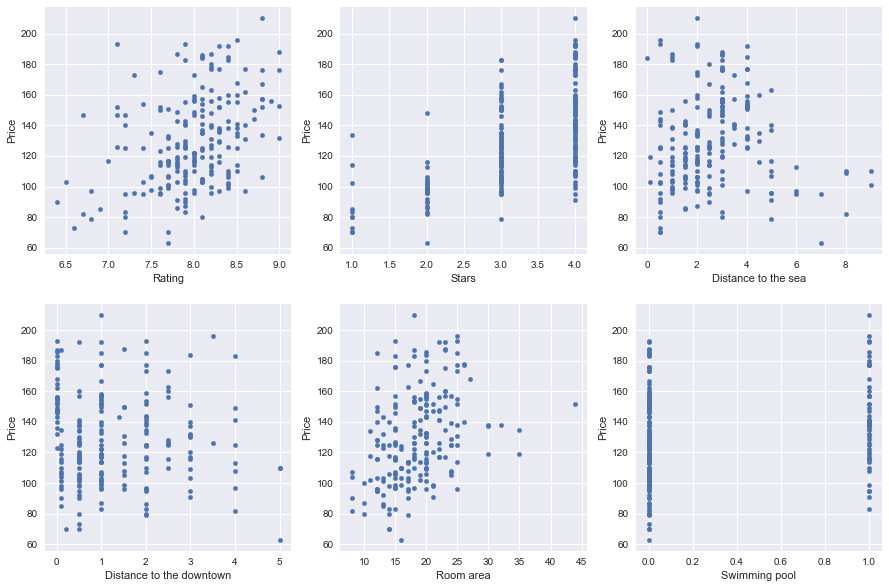

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for idx, feature in enumerate(data.columns[1:-1]):
    data.plot(feature, 'Price', subplots=True, kind='scatter', ax=axes[int(idx / 3), int(idx % 3)])

### 1.2 Проверка наличия пропусков

In [7]:
def checkNANs(dataframe):
    print("Есть ли пропуски в датафрейме?: ", dataframe.isnull().values.any())

In [8]:
checkNANs(data)

Есть ли пропуски в датафрейме?:  True


Найдем пропуски:

In [9]:
nan_indexes = data.isnull().any(axis=1)
data[nan_indexes]

,Hotel name,Rating,Stars,Distance to the sea,Distance to the downtown,Room area,Swimming pool,Price
6,Hotel Barbara,6.6,1.0,0.5,0.5,NaN,0,73
58,Holiday Inn Express Barcelona City 22,7.6,NaN,0.5,1.5,25.0,0,96


### 1.3 Заполнение пропусков

In [10]:
mean_dict = data.mean() # cacl mean
for key in mean_dict.keys(): # round values
    mean_dict[key] = int(mean_dict[key])

Округленные средние значения

In [11]:
mean_dict

Rating                        7.0
Stars                         3.0
Distance to the sea           2.0
Distance to the downtown      1.0
Room area                    18.0
Swimming pool                 0.0
Price                       129.0
dtype: float64

Заполняем средними

In [12]:
data = data.fillna(mean_dict)

Проверим заполнение пропусков средним значением:

In [13]:
data[nan_indexes]

,Hotel name,Rating,Stars,Distance to the sea,Distance to the downtown,Room area,Swimming pool,Price
6,Hotel Barbara,6.6,1.0,0.5,0.5,18.0,0,73
58,Holiday Inn Express Barcelona City 22,7.6,3.0,0.5,1.5,25.0,0,96


In [14]:
checkNANs(data)

Есть ли пропуски в датафрейме?:  False


## 2. Проверка данных

### 2.1 Построение корреляционной матрицы

In [15]:
data.corr()

,Rating,Stars,Distance to the sea,Distance to the downtown,Room area,Swimming pool,Price
Rating,1.000000,0.186994,-0.021557,-0.128974,0.191710,0.202255,0.405103
Stars,0.186994,1.000000,0.163200,0.177517,0.467148,0.298196,0.593109
Distance to the sea,-0.021557,0.163200,1.000000,0.333458,0.073053,0.054242,0.004539
Distance to the downtown,-0.128974,0.177517,0.333458,1.000000,0.147002,0.158823,-0.109614
Room area,0.191710,0.467148,0.073053,0.147002,1.000000,0.265290,0.362466
Swimming pool,0.202255,0.298196,0.054242,0.158823,0.265290,1.000000,0.253810
Price,0.405103,0.593109,0.004539,-0.109614,0.362466,0.253810,1.000000


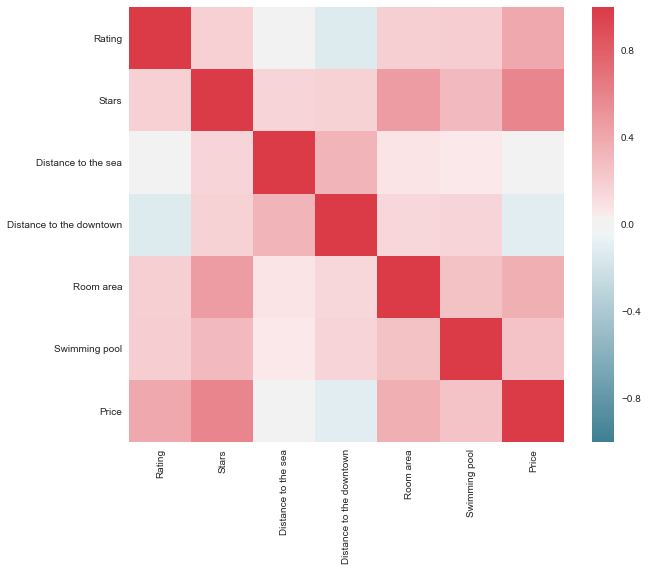

In [16]:
f, ax = plt.subplots(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

### 2.2 Удаление малоинформативных признаков

Как видно из корреляционной матрицы, зависимость между ценой и расстоянием до моря/центра города очень слабая (меньше 20%). <br>Поэтому, удалим эти признаки. 

In [17]:
data = data.drop(['Distance to the sea'], axis = 1)

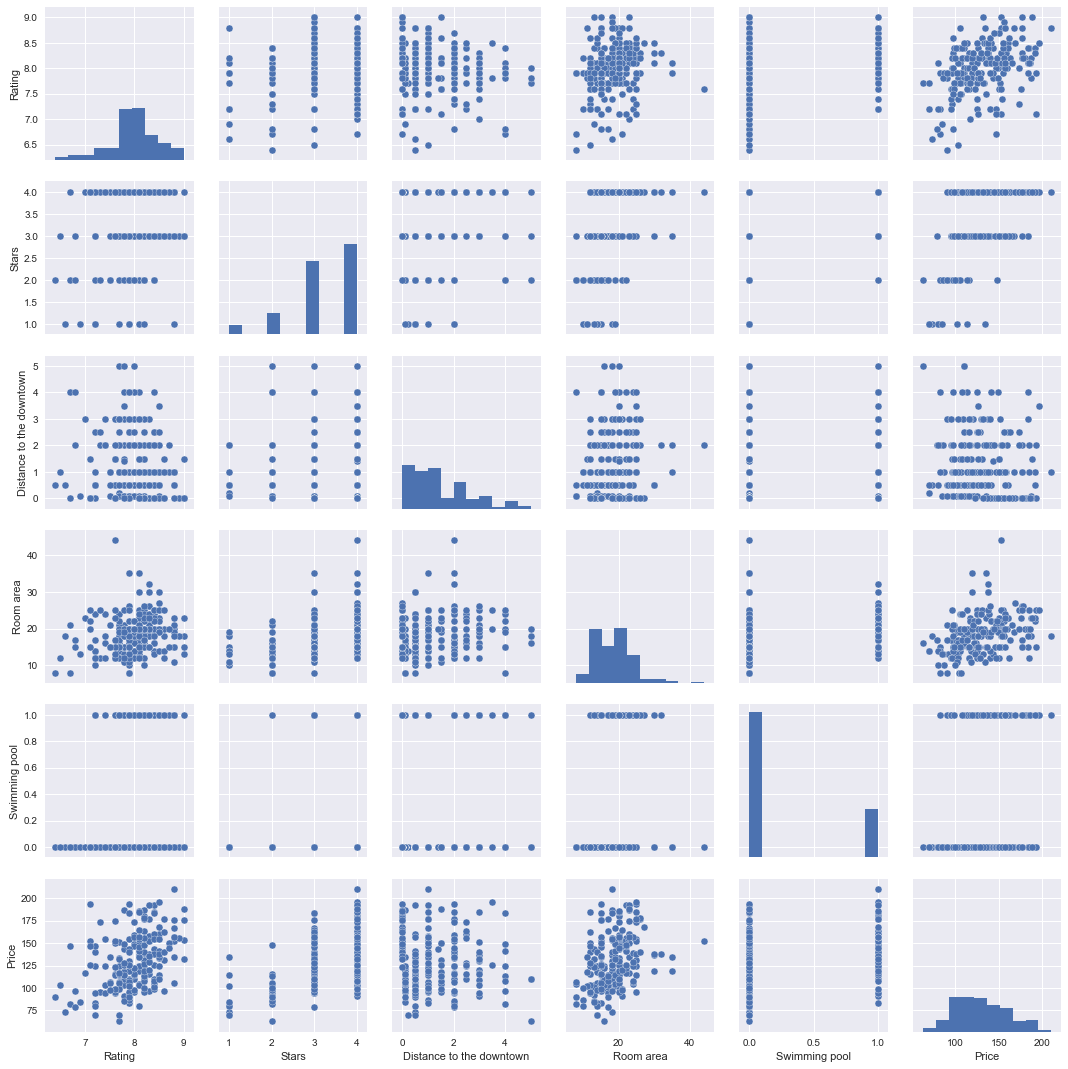

In [18]:
sns.pairplot(data)
plt.show()

## 3. Обучение модели

In [19]:
X_data = data.ix[:,1:].copy()

### 3.1 Обучение МНК

In [20]:
X_data=X_data.rename(columns = {'Distance to the downtown':'Downtown', 'Room area':'Room', 'Swimming pool': 'Pool'})

In [21]:
results = smf.glsar(formula='np.log(Price) ~ Rating + C(Stars) + np.log(Downtown + 1) + np.log(Room) + C(Pool)', data=X_data).fit()

In [22]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           GLSAR Regression Results                           
==============================================================================
Dep. Variable:          np.log(Price)   R-squared:                       0.533
Model:                          GLSAR   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     32.48
Date:                Mon, 15 May 2017   Prob (F-statistic):           7.85e-30
Time:                        22:24:27   Log-Likelihood:                 90.428
No. Observations:                 207   AIC:                            -164.9
Df Residuals:                     199   BIC:                            -138.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept                3.3610      0.213     15.773      0.000         2.941     3.781
C(Stars)[T.2.0]          0.1130      0.061      1.855      0.065        -0.007     0.233
C(Stars)[T.3.0]          0.2855      0.055      5.177      0.000         0.177     0.394
C(Stars)[T.4.0]          0.4405      0.057      7.742      0.000         0.328     0.553
C(Pool)[T.1]             0.0166      0.028      0.601      0.549        -0.038     0.071
Rating                   0.1278      0.024      5.305      0.000         0.080     0.175
np.log(Downtown + 1)    -0.0939      0.024     -3.958      0.000        -0.141    -0.047
np.log(Room)             0.0680      0.048      1.428      0.155        -0.026     0.162
==============================================================================
Omnibus:                        1.892   Durbin-Watson:                   1.164
Prob(Omnibus):                  0.388   Jarque-Bera (JB):                1.967
Skew:                           0.219   Prob(JB):                        0.374
Kurtosis:                       2.808   Cond. No.                         167.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
from statsmodels.stats.diagnostic import acorr_breush_godfrey
abg = acorr_breush_godfrey(results, 1)
print(abg)

(40.494781043352368, 1.9714192063409125e-10, 47.73416015718589, 6.4439008125851751e-11)


### 4.2 Оценка качества

In [31]:
def testModel(results, name, y_true, y_pred, resid):
    print('Params for ' + name + ':')
    print(results.params)
    print('\n')
    
    print('MSE ' + name + ':', mean_squared_error(y_true, y_pred))
    print('\n')
    
    print('Heteroscedasticity test:')
    hb = smsdia.het_breushpagan(resid, results.model.exog)
    print('LM: ', hb[0])
    print('LM_pvalue: ', hb[1])
    print('fvalue: ', hb[2])
    print('f_value: ', hb[3])
    print('\n')
    
    name = ['F statistic', 'p-value']
    test = sms.het_goldfeldquandt(results.resid, results.model.exog)
    print(lzip(name, test))
    
    print('\n')
    print('Jarque-Bera test:')
    name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
    test = sms.jarque_bera(resid)
    print(lzip(name, test))
    
    print('\n')
    print('Multicollinearity: condition number')
    print(np.linalg.cond(results.model.exog))
    
    print('\n')
    print('Ramsey test:')
    print(reset_ramsey(results))
    print('\n')
    
    try:
        fig, ax = plt.subplots(figsize=(8,6))
        fig = plot_leverage_resid2(results, ax = ax)
        plt.show()
    except Exception:
        print('Чет не рисуется:c\n')
        # ignored
        
        
    X_plot = np.linspace(0,1,100)
    plt.plot(results.fittedvalues)
    plt.plot(np.log(X_data['Price']))
    plt.show()
    
    
    X_plot = np.linspace(0,1,208)
    plt.figure(figsize=(20,10))
    plt.scatter(X_plot, results.resid)
    plt.show()

Params for OLS:
Intercept               3.360975
C(Stars)[T.2.0]         0.112995
C(Stars)[T.3.0]         0.285453
C(Stars)[T.4.0]         0.440458
C(Pool)[T.1]            0.016581
Rating                  0.127776
np.log(Downtown + 1)   -0.093885
np.log(Room)            0.067954
dtype: float64


MSE OLS: 0.0248605633392


Heteroscedasticity test:
LM:  5.93028915396
LM_pvalue:  0.547912378767
fvalue:  0.838506831433
f_value:  0.556549837954


[('F statistic', 1.2557125155257916), ('p-value', 0.13319450720821072)]


Jarque-Bera test:
[('Jarque-Bera', 1.665824745683113), ('Chi^2 two-tail prob.', 0.43478119569514284), ('Skew', 0.1967810447193664), ('Kurtosis', 2.806817626747574)]


Multicollinearity: condition number
167.537044913


Ramsey test:
<F test: F=array([[ 0.70455099]]), p=0.5897013617572515, df_denom=196, df_num=4>


Чет не рисуется:c



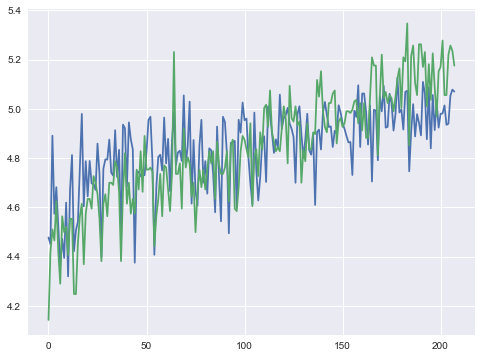

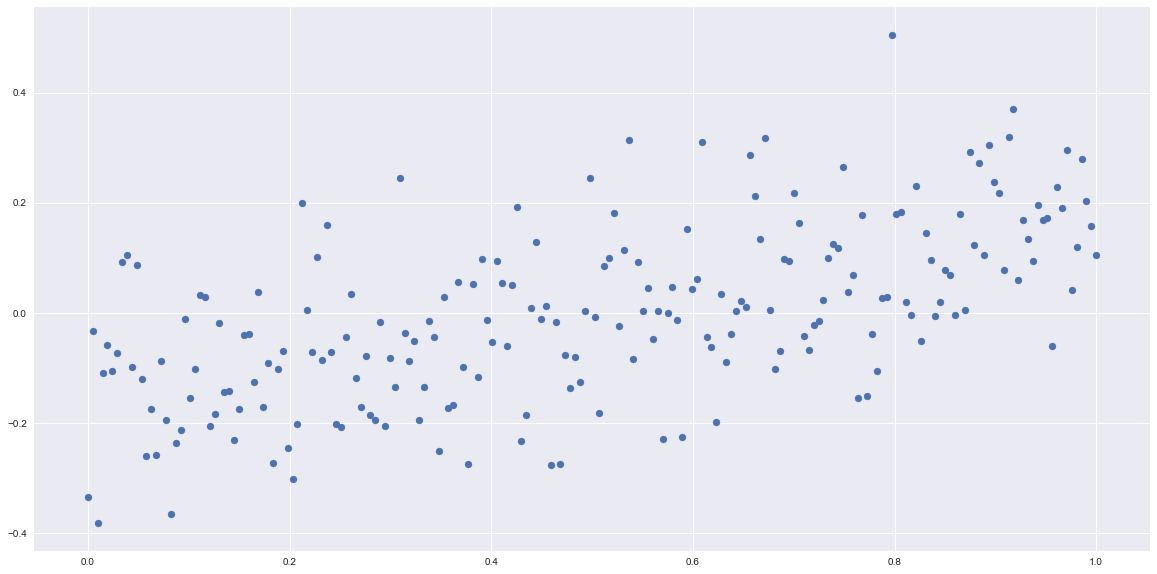

In [32]:
testModel(results, 'OLS', np.log(X_data['Price'].values), results.fittedvalues, results.resid.values)

Нулевая гипотеза: дисперсия остатков не зависит от переменных 
Альтернативная гипотеза: дисперсия остатков зависит от переменных 

Т.к. LM > LM_pvalue,присутствует гетероскедастичность

Корректируем гетероскедастичность (делим на weights - стандартные отклонения)

In [363]:
def fgls(model):
    return sm.WLS(model.endog, model.exog,
                  weights=1./np.exp(sm.GLSAR(np.log(model.fit().resid ** 2), model.exog).fit().predict()))

In [364]:
wls_results = fgls(results.model).fit()

In [365]:
wls_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.585
Model:                            WLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     40.31
Date:                Mon, 15 May 2017   Prob (F-statistic):           5.09e-35
Time:                        18:28:08   Log-Likelihood:                 91.679
No. Observations:                 208   AIC:                            -167.4
Df Residuals:                     200   BIC:                            -140.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          3.4879      0.195     17.873      0.000         3.103     3.873
x1             0.1294      0.062      2.102      0.037         0.008     0.251
x2             0.3110      0.060      5.159      0.000         0.192     0.430
x3             0.4814      0.062      7.803      0.000         0.360     0.603
x4             0.0087      0.028      0.309      0.758        -0.047     0.064
x5             0.1109      0.022      4.944      0.000         0.067     0.155
x6            -0.1148      0.023     -4.983      0.000        -0.160    -0.069
x7             0.0647      0.045      1.452      0.148        -0.023     0.152
==============================================================================
Omnibus:                        1.086   Durbin-Watson:                   1.226
Prob(Omnibus):                  0.581   Jarque-Bera (JB):                1.178
Skew:                           0.163   Prob(JB):                        0.555
Kurtosis:                       2.827   Cond. No.                         157.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Params for WLS:
[ 3.48792599  0.12938692  0.3109932   0.48136874  0.00868558  0.11092934
 -0.11476849  0.06467835]


MSE WLS: 0.0249806442286


Heteroscedasticity test:
LM:  7.19373719019
LM_pvalue:  0.408990791784
fvalue:  1.02355048799
f_value:  0.415786811646


[('F statistic', 1.2557125155257896), ('p-value', 0.1331945072082128)]


Jarque-Bera test:
[('Jarque-Bera', 1.7586112632426558), ('Chi^2 two-tail prob.', 0.41507102383587535), ('Skew', 0.22152075370848076), ('Kurtosis', 2.9185696191460897)]


Multicollinearity: condition number
167.537044913


Ramsey test:
<F test: F=array([[ 0.78236152]]), p=0.5378655824682508, df_denom=196, df_num=4>


Чет не рисуется:c



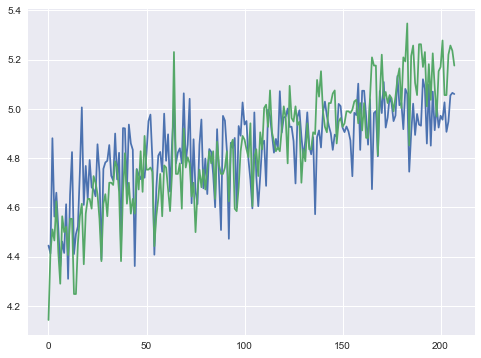

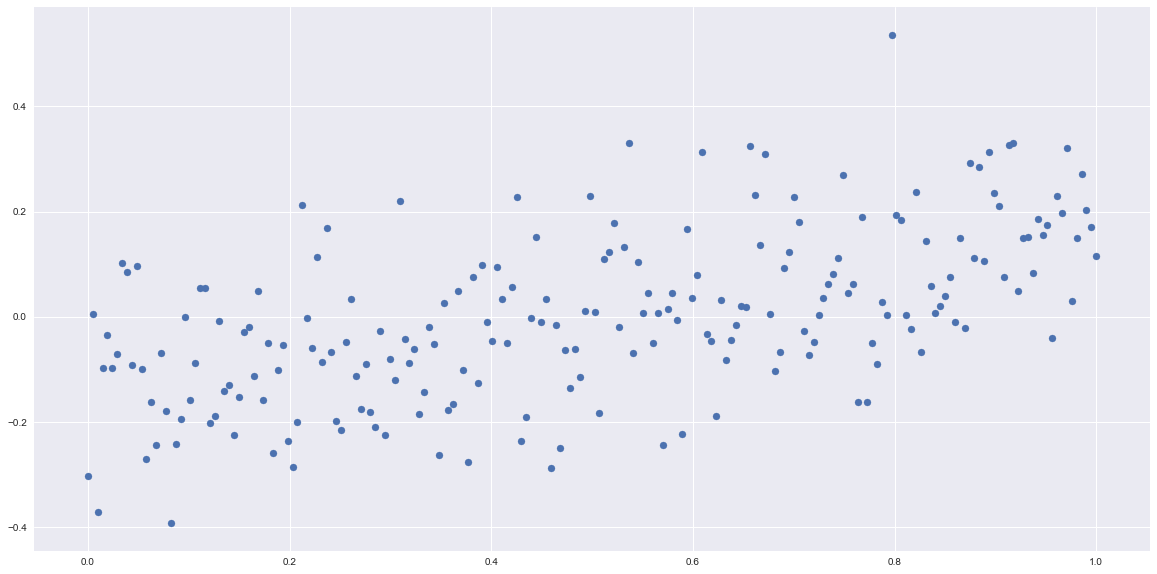

In [366]:
testModel(wls_results, 'WLS', np.log(X_data['Price'].values), wls_results.fittedvalues, wls_results.resid)